In [1]:
## Opslaan van het model voor op flask
# Als dit niet lukt kijk dan naar model_test

In [2]:
!ls

frcnn_test_resnet.ipynb
frcnn_test_resnet_model_1_hier.ipynb
frcnn_test_resnet_model_2_hier.ipynb
frcnn_test_resnet_model_2_hier_per_soort.ipynb
frcnn_test_resnet_model_2_hier_per_soort_nieuwe_f.ipynb
frcnn_test_resnet_model_3_hier.ipynb
frcnn_test_resnet_model_hier.ipynb
frcnn_test_resnet_model_test_hier.ipynb
frcnn_test_resnet_model_test_hier_nieuwe_waarde.ipynb
frcnn_train_resnet.ipynb
frcnn_train_resnet_model_1_hier.ipynb
frcnn_train_resnet_model_2_hier.ipynb
frcnn_train_resnet_model_3_hier.ipynb
frcnn_train_resnet_model_hier.ipynb
frcnn_train_resnet_model_test_hier.ipynb
model
model_1
model_2
model_2_frcnn_test_RPN_hier_per_soort.ipynb
model_2_test_verslag.ipynb
model_3
model_4
model_4_frcnn_train_resnet_hier.ipynb
model_4_test_algemeen.ipynb
model_4_vorm_om.ipynb
model_5
model_5_frcnn_train_extra_33.ipynb
model_5_save_as_one_model.ipynb
model_5_test_algemeen.ipynb
model_5_test.ipynb
model_5_test_per_soort.ipynb
model_5_train_extra_33_opgekuist.ipynb
model_5_vorm_om.ipynb
model_6


### Import libs

In [3]:
import os


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import random
import pprint
import shutil
import sys
import time
import numpy as np
import pickle
import math
import cv2

import copy



from matplotlib import pyplot as plt
import tensorflow as tf

import pandas as pd

from sklearn.metrics import average_precision_score

from sklearn.metrics import average_precision_score, precision_recall_curve


from tensorflow import keras

from tensorflow.keras import backend as K


from tensorflow.keras.layers import Flatten, Dense, Input, MaxPooling2D, Dropout, Activation, ZeroPadding2D, \
    BatchNormalization, \
    Conv2D, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed, AveragePooling2D
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer


from zipfile import ZipFile


#### Config setting

In [5]:
class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'resnet50'

		# Setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# Anchor box scales
    # Note that if im_size is smaller, anchor_box_scales should be scaled
    # Original anchor_box_scales in the paper is [128, 256, 512]
		self.anchor_box_scales = [64, 128, 256]   # [16, 32, 64]

		# Anchor box ratios
		self.anchor_box_ratios = [[1, 1], [0.75, 0.75], [1.25, 1.25]]
        
		# Size to resize the smallest side of the image
		# Original setting in paper is 600. Set to 300 in here to save training time
		self.im_size = 600

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 16

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		self.model_path = None

#### Parser the data from annotation file

In [6]:
def get_data(input_path):
	"""Parser the data from annotation file
	
	Args:
		input_path: annotation file path

	Returns:
		all_data: list(filepath, width, height, list(bboxes))
		classes_count: dict{key:class_name, value:count_num} 
			e.g. {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745}
		class_mapping: dict{key:class_name, value: idx}
			e.g. {'Car': 0, 'Mobile phone': 1, 'Person': 2}
	"""
	found_bg = False
	all_imgs = {}

	classes_count = {}

	class_mapping = {}

	visualise = True

	i = 1
	
	with open(input_path,'r') as f:

		print('Parsing annotation files')

		for line in f:

			# Print process
			sys.stdout.write('\r'+'idx=' + str(i))
			i += 1

			line_split = line.strip().split(',')

			# Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
			# Note:
			#	One path_filename might has several classes (class_name)
			#	x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
			#	(x1, y1) top left coordinates; (x2, y2) bottom right coordinates
			#   x1,y1-------------------
			#	|						|
			#	|						|
			#	|						|
			#	|						|
			#	---------------------x2,y2

			(filename,x1,y1,x2,y2,class_name) = line_split

			if class_name not in classes_count:
				classes_count[class_name] = 1
			else:
				classes_count[class_name] += 1

			if class_name not in class_mapping:
				if class_name == 'bg' and found_bg == False:
					print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
					found_bg = True
				class_mapping[class_name] = len(class_mapping)

			if filename not in all_imgs:
				all_imgs[filename] = {}
				
				img = cv2.imread(filename)
				(rows,cols) = img.shape[:2]
				all_imgs[filename]['filepath'] = filename
				all_imgs[filename]['width'] = cols
				all_imgs[filename]['height'] = rows
				all_imgs[filename]['bboxes'] = []
				####### INTERESSANT         
				# if np.random.randint(0,6) > 0:
				# 	all_imgs[filename]['imageset'] = 'trainval'
				# else:
				# 	all_imgs[filename]['imageset'] = 'test'

			all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})
# 			print('all_imgs:',all_imgs)

		all_data = []
# 		print('all_data',all_data)   
		for key in all_imgs:
			all_data.append(all_imgs[key])
# 			print('key',key)   
		
		# make sure the bg class is last in the list
		if found_bg:
			if class_mapping['bg'] != len(class_mapping) - 1:
				key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
				val_to_switch = class_mapping['bg']
				class_mapping['bg'] = len(class_mapping) - 1
				class_mapping[key_to_switch] = val_to_switch
		
		return all_data, classes_count, class_mapping

#### Define ROI Pooling Convolutional Layer

In [7]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = 'tf'
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Identity Block

In [8]:
# # identity_block

# def identity_block(input_tensor, kernel_size, filters, stage, block, trainable=True):
#     """
#     Implementation of the identity block as defined in Figure 3

#     Arguments:
#     input_tensor -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
#     kernel_size -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main path
#     stage -- integer, used to name the layers, depending on their position in the network
#     block -- string/character, used to name the layers, depending on their position in the network

#     Returns:
#     X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
#     """

#     # defining name basis
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'

#     # Retrieve Filters
#     F1, F2, F3 = filters


#     # First component of main path
#     X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(input_tensor)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
#     X = Activation('relu')(X)

#     # Second component of main path
#     X = Conv2D(filters = F2, kernel_size = (kernel_size, kernel_size), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
#     X = Activation('relu')(X)

#     # Third component of main path
#     X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

#     # Final step: Add shortcut value to main path, and pass it through a RELU activation
#     X = Add()([X, input_tensor]) 
#     X = Activation('relu')(X)

#     return X

In [9]:
# def identity_block_td(input_tensor, kernel_size, filters, stage, block, trainable=True):
#     """
#     Implementation of the identity block as defined in Figure 3

#     Arguments:
#     input_tensor -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
#     kernel_size -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main path
#     stage -- integer, used to name the layers, depending on their position in the network
#     block -- string/character, used to name the layers, depending on their position in the network

#     Returns:
#     X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
#     """

#     # defining name basis
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'

#     # Retrieve Filters
#     F1, F2, F3 = filters


#     # First component of main path
#     X = TimeDistributed(Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '2a')(input_tensor)
#     X = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '2a')(X)
#     X = Activation('relu')(X)

#     # Second component of main path
#     X = TimeDistributed(Conv2D(filters = F2, kernel_size = (kernel_size, kernel_size), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '2b')(X)
#     X = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '2b')(X)
#     X = Activation('relu')(X)

#     # Third component of main path
#     X = TimeDistributed(Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '2c')(X)
#     X = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '2c')(X)

#     # Final step: Add shortcut value to main path, and pass it through a RELU activation
#     X = Add()([X, input_tensor]) 
#     X = Activation('relu')(X)

#     return X

## Conv Block
### Conv block

In [10]:
# def convolutional_block(input_tensor, f, filters, stage, block, s = 2):
#     """
#     Implementation of the convolutional block as defined in Figure 4

#     Arguments:
#     input_tensor -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
#     f -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main path
#     stage -- integer, used to name the layers, depending on their position in the network
#     block -- string/character, used to name the layers, depending on their position in the network
#     s -- Integer, specifying the stride to be used

#     Returns:
#     X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
#     """

#     # defining name basis
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'

#     # Retrieve Filters
#     F1, F2, F3 = filters

#     # HIER Conv2D(F1,(3,3)) veranderd naar (1,1)
#     # First component of main path 
#     X = Conv2D(F1, (1 ,1), strides = (s,s), padding = 'same', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(input_tensor)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
#     X = Activation('relu')(X)

#     # Second component of main path
#     X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
#     X = Activation('relu')(X)

#     # Third component of main path
#     X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

#     X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'same', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(input_tensor)
#     X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

#     # Final step: Add shortcut value to main path, and pass it through a RELU activation
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)

#     return X

## Conv block td
conv block time distributed

In [11]:
# def convolutional_block_td(input_tensor, f, filters, stage, block, s = 2):
#     """
#     Implementation of the convolutional block as defined in Figure 4

#     Arguments:
#     input_tensor -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
#     f -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main path
#     stage -- integer, used to name the layers, depending on their position in the network
#     block -- string/character, used to name the layers, depending on their position in the network
#     s -- Integer, specifying the stride to be used

#     Returns:
#     X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
#     """

#     # defining name basis
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'

#     bn_axis = 3
    
#     # Retrieve Filters
#     F1, F2, F3 = filters


#     # First component of main path 
#     X = TimeDistributed(Conv2D(F1, (1,1), strides = (s,s), padding = 'same', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '2a')(input_tensor)
#     X = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '2a')(X)
#     X = Activation('relu')(X)

#     # Second component of main path
#     X = TimeDistributed(Conv2D(F2, (f, f), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '2b')(X)
#     X = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '2b')(X)
#     X = Activation('relu')(X)

#     # Third component of main path
#     X = TimeDistributed(Conv2D(F3, (1, 1), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '2c')(X)
#     X = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '2c')(X)

#     X_shortcut = TimeDistributed(Conv2D(F3, (1,1), strides = (s,s), padding = 'same', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '1')(input_tensor)
#     X_shortcut = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '1')(X_shortcut)

#     # Final step: Add shortcut value to main path, and pass it through a RELU activation
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)

#     return X

#### Resnet50 model

In [12]:
# def get_img_output_length(width, height):
#     #function to calculate final layer's feature map (of base model) size according to input image size
#     def get_output_length(input_length):
#         input_float = input_length + 0.0
#         test = math.ceil(input_float/16) 
#         # //16 omdat we 4 lagen hebben die telkens halveren (/2)
# #         test = input_length//16
#         #print('input_float',input_float)
#         #print('test',test)
#         return test
#     return get_output_length(width), get_output_length(height)    

# def nn_base(input_tensor=None, trainable=False):

#     input_shape = (None, None, 3)
    
#     classes = 1

#     if input_tensor is None:
#         img_input = Input(shape=input_shape)
#     else:
#         if not K.is_keras_tensor(input_tensor):
#             img_input = Input(tensor=input_tensor, shape=input_shape)
#         else:
#             img_input = input_tensor
#     bn_axis = 3


#     # Zero-Padding
#     X = ZeroPadding2D((3, 3))(img_input)

#     # Stage 1
#     X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name='bn_conv1')(X)
#     X = Activation('relu')(X)
#     X = MaxPooling2D((3, 3), strides=(2, 2))(X)

#     # Stage 2
#     X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
#     X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
#     X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

#     ### START CODE HERE ###

#     # Stage 3 (≈4 lines)
#     X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

#     # Stage 4 (≈6 lines)
#     #X = MaxPooling2D((2, 2), strides=(2, 2), name='BLOCK_4')(X)
#     X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')


# #     # Stage 5 (≈3 lines)
# #     X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
# #     X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
# #     X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

#     # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
#     # X = AveragePooling2D((2,2), name="avg_pool")(X)

#     ### END CODE HERE ###

#     # output layer
#     ####################################
#     # Dit moet nog uit commentaar
#     # Alleen de Flatten
#     #X = Flatten()(X)
    
#     # X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
#     # Create model
#     # model = Model(inputs = X_input, outputs = X, name='ResNet50')

#     return X

####  RPN layer

In [13]:
# def rpn_layer(base_layers, num_anchors):
#     """Create a rpn layer
#         Step1: Pass through the feature map from base layer to a 3x3 512 channels convolutional layer
#                 Keep the padding 'same' to preserve the feature map's size
#         Step2: Pass the step1 to two (1,1) convolutional layer to replace the fully connected layer
#                 classification layer: num_anchors (9 in here) channels for 0, 1 sigmoid activation output
#                 regression layer: num_anchors*4 (36 in here) channels for computing the regression of bboxes with linear activation
#     Args:
#         base_layers: vgg in here
#         num_anchors: 9 in here

#     Returns:
#         [x_class, x_regr, base_layers]
#         x_class: classification for whether it's an object
#         x_regr: bboxes regression
#         base_layers: vgg in here
#     """


#     x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

#     x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
#     x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

#     return [x_class, x_regr, base_layers]

####  Classifier layer

In [14]:
# def classifier_layers(X, input_shape):
#     # compile times on theano tend to be very high, so we use smaller ROI pooling regions to workaround
#     # (hence a smaller stride in the region that follows the ROI pool)
#     #X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    
#     X = convolutional_block_td(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s = 2)
    
#     X = identity_block_td(X, 3, [512, 512, 2048], stage=5, block='b')
#     X = identity_block_td(X, 3, [512, 512, 2048], stage=5, block='c')
#     X = TimeDistributed(AveragePooling2D((2,2)), name='avg_pool')(X)

#     return X

### Classifier

In [15]:
# def classifier_model(base_layers, input_rois, num_rois, nb_classes = 4):
#     """Create a classifier layer
    
#     Args:
#         base_layers: vgg
#         input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
#         num_rois: number of rois to be processed in one time (4 in here)

#     Returns:
#         list(out_class, out_regr)
#         out_class: classifier layer output
#         out_regr: regression layer output
#     """

#     input_shape = (num_rois,7,7,512)

#     pooling_regions = 7
    

#     # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
#     # num_rois (4) 7x7 roi pooling
#     out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    
#     out = classifier_layers(out_roi_pool, input_shape=input_shape)

#     # Flatten the convlutional layer and connected to 2 FC and 2 dropout
#     out = TimeDistributed(Flatten(name='flatten'))(out)
#     out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
#     out = TimeDistributed(Dropout(0.5))(out)
#     out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
#     out = TimeDistributed(Dropout(0.5))(out)

#     # There are two output layer
#     # out_class: softmax acivation function for classify the class name of the object
#     # out_regr: linear activation function for bboxes coordinates regression
#     out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
#     # note: no regression target for bg class
#     out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

#     return [out_class, out_regr]
    

#### Calculate IoU (Intersection of Union)

In [16]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

#### Calculate the rpn for all anchors of all images

In [17]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
	"""(Important part!) Calculate the rpn for all anchors 
		If feature map has shape 38x50=1900, there are 1900x9=17100 potential anchors
	
	Args:
		C: config
		img_data: augmented image data
		width: original image width (e.g. 600)
		height: original image height (e.g. 800)
		resized_width: resized image width according to C.im_size (e.g. 300)
		resized_height: resized image height according to C.im_size (e.g. 400)
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

	Returns:
		y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
			y_is_box_valid: 0 or 1 (0 means the box is invalid, 1 means the box is valid)
			y_rpn_overlap: 0 or 1 (0 means the box is not an object, 1 means the box is an object)
		y_rpn_regr: list(num_bboxes, 4*y_rpn_overlap + y_rpn_regr)
			y_rpn_regr: x1,y1,x2,y2 bunding boxes coordinates
	"""
	downscale = float(C.rpn_stride) 
	anchor_sizes = C.anchor_box_scales   # 128, 256, 512
	anchor_ratios = C.anchor_box_ratios  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
	num_anchors = len(anchor_sizes) * len(anchor_ratios) # 3x3=9

	# calculate the output map size based on the network architecture
	(output_width, output_height) = img_length_calc_function(resized_width, resized_height)

	n_anchratios = len(anchor_ratios)    # 3
	
	# initialise empty output objectives
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

	num_bboxes = len(img_data['bboxes'])

	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

	# get the GT box coordinates, and resize to account for image resizing
	gta = np.zeros((num_bboxes, 4))
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
	
	# rpn ground truth

	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			
			for ix in range(output_width):					
				# x-coordinates of the current anchor box	
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2	
				
				# ignore boxes that go across image boundaries					
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for jy in range(output_height):

					# y-coordinates of the current anchor box
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
					if y1_anc < 0 or y2_anc > resized_height:
						continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
					bbox_type = 'neg'

					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
					best_iou_for_loc = 0.0

					for bbox_num in range(num_bboxes):
						
						# get IOU of the current GT box and the current anchor box
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc)/2.0
							cya = (y1_anc + y2_anc)/2.0

							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							# tx = (x - xa) / wa
							# ty = (y - ya) / ha
							# tw = log(w / wa)
							# th = log(h / ha)
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
						
						if img_data['bboxes'][bbox_num]['class'] != 'bg':

							# all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

							# we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
							if curr_iou > C.rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1
								# we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
								if curr_iou > best_iou_for_loc:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)

							# if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
							if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
								# gray zone between neg and pos
								if bbox_type != 'pos':
									bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
					if bbox_type == 'neg':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'neutral':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'pos':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
						y_rpn_regr[jy, ix, start:start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region

	for idx in range(num_anchors_for_bbox.shape[0]):
		if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
			if best_anchor_for_bbox[idx, 0] == -1:
				continue
			y_is_box_valid[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			y_rpn_overlap[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
			y_rpn_regr[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

	num_pos = len(pos_locs[0])

	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
	num_regions = 256

	if len(pos_locs[0]) > num_regions/2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions/2

	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

#### Get new image size and augment the image

In [18]:
def get_new_img_size(width, height, img_min_side=600):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

	if augment:
		rows, cols = img.shape[:2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2        
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

#### Generate the ground_truth anchors

In [19]:
def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
	""" Yield the ground-truth anchors as Y (labels)
		
	Args:
		all_img_data: list(filepath, width, height, list(bboxes))
		C: config
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size
		mode: 'train' or 'test'; 'train' mode need augmentation

	Returns:
		x_img: image data after resized and scaling (smallest size = 300px)
		Y: [y_rpn_cls, y_rpn_regr]
		img_data_aug: augmented image data (original image with augmentation)
		debug_img: show image for debug
		num_pos: show number of positive anchors for debug
	"""
	while True:

		for img_data in all_img_data:
			try:

				# read in image, and optionally add augmentation

				if mode == 'train':
					img_data_aug, x_img = augment(img_data, C, augment=True)
				else:
					img_data_aug, x_img = augment(img_data, C, augment=False)

				(width, height) = (img_data_aug['width'], img_data_aug['height'])
				(rows, cols, _) = x_img.shape

				assert cols == width
				assert rows == height

				# get image dimensions for resizing
				(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

				# resize the image so that smalles side is length = 300px
				x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
				debug_img = x_img.copy()

				try:
					y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
				except:
					continue

				# Zero-center by mean pixel, and preprocess image

				x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
				x_img = x_img.astype(np.float32)
				x_img[:, :, 0] -= C.img_channel_mean[0]
				x_img[:, :, 1] -= C.img_channel_mean[1]
				x_img[:, :, 2] -= C.img_channel_mean[2]
				x_img /= C.img_scaling_factor

				x_img = np.transpose(x_img, (2, 0, 1))
				x_img = np.expand_dims(x_img, axis=0)

				y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

				x_img = np.transpose(x_img, (0, 2, 3, 1))
				y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
				y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

				yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

			except Exception as e:
				print(e)
				continue

In [20]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
	# code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
	# if there are no boxes, return an empty list
  
    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
	if len(boxes) == 0:
		return []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	np.testing.assert_array_less(x1, x2)
	np.testing.assert_array_less(y1, y2)

	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes	
	pick = []

	# calculate the areas
	area = (x2 - x1) * (y2 - y1)

	# sort the bounding boxes 
	idxs = np.argsort(probs)

	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the intersection

		xx1_int = np.maximum(x1[i], x1[idxs[:last]])
		yy1_int = np.maximum(y1[i], y1[idxs[:last]])
		xx2_int = np.minimum(x2[i], x2[idxs[:last]])
		yy2_int = np.minimum(y2[i], y2[idxs[:last]])

		ww_int = np.maximum(0, xx2_int - xx1_int)
		hh_int = np.maximum(0, yy2_int - yy1_int)

		area_int = ww_int * hh_int

		# find the union
		area_union = area[i] + area[idxs[:last]] - area_int

		# compute the ratio of overlap
		overlap = area_int/(area_union + 1e-6)

		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlap_thresh)[0])))

		if len(pick) >= max_boxes:
			break

	# return only the bounding boxes that were picked using the integer data type
	boxes = boxes[pick].astype("int")
	probs = probs[pick]
	return boxes, probs

def apply_regr_np(X, T):
	"""Apply regression layer to all anchors in one feature map

	Args:
		X: shape=(4, 18, 25) the current anchor type for all points in the feature map
		T: regression layer shape=(4, 18, 25)

	Returns:
		X: regressed position and size for current anchor
	"""
	try:
		x = X[0, :, :]
		y = X[1, :, :]
		w = X[2, :, :]
		h = X[3, :, :]

		tx = T[0, :, :]
		ty = T[1, :, :]
		tw = T[2, :, :]
		th = T[3, :, :]

		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy

		w1 = np.exp(tw.astype(np.float64)) * w
		h1 = np.exp(th.astype(np.float64)) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.

		x1 = np.round(x1)
		y1 = np.round(y1)
		w1 = np.round(w1)
		h1 = np.round(h1)
		return np.stack([x1, y1, w1, h1])
	except Exception as e:
		print(e)
		return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
	try:
		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy
		w1 = math.exp(tw) * w
		h1 = math.exp(th) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.
		x1 = int(round(x1))
		y1 = int(round(y1))
		w1 = int(round(w1))
		h1 = int(round(h1))

		return x1, y1, w1, h1

	except ValueError:
		return x, y, w, h
	except OverflowError:
		return x, y, w, h
	except Exception as e:
		print(e)
		return x, y, w, h

In [21]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 9) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 36) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# Might be (4, 18, 25, 9) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map 
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result



---





---



In [30]:
base_path = 'model_5/'
naam_model = '200_epoch/'

model_rpn_path = base_path + naam_model + 'my_model_test_rpn'
model_classifier_path = base_path + naam_model + 'my_model_test_clas'
model_classifier_only_path = base_path + naam_model + 'my_model_test_clas_only'


test_path =  '../../data/text_files/deel_1_tot_5_zonder_augment.txt'
# test_base_path = '../../data/augmentatie/finale_opdeling/validatie_1'

# test_path =  '../../data/text_files/validatie_set_delen.txt'
# test_base_path = '../../data/augmentatie/validatie_set_delen'

# test_path = '../../data/text_files/deel_1_training.txt' # Training data (annotation file)
test_base_path = '../../data/augmentatie/finale_opdeling/deel_1_training' # Directory to save the test images

config_output_filename = os.path.join(base_path, 'model_resnet_config.pickle')

In [31]:
with open(config_output_filename, 'rb') as f_in:
    C = pickle.load(f_in)


# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

In [32]:
print(C.class_mapping)

{'huidmond': 0, 'bg': 1}


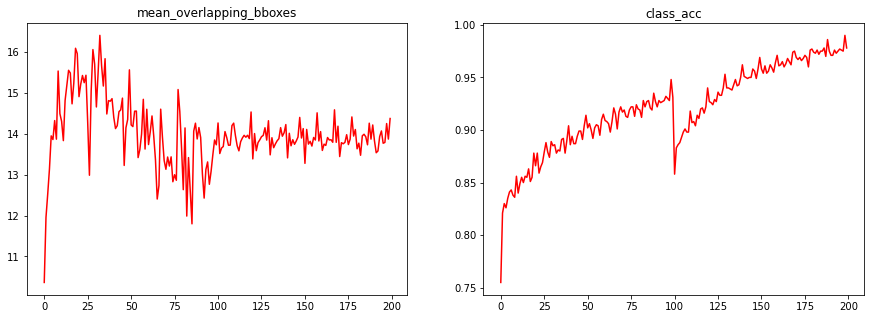

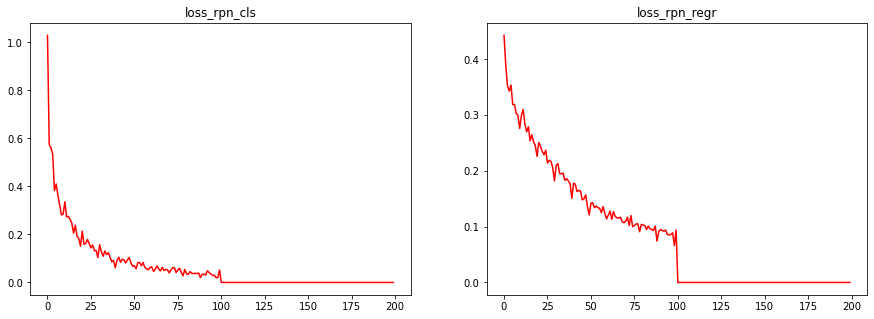

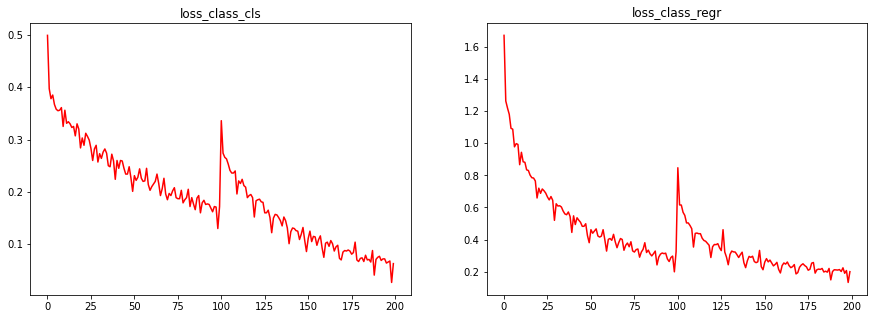

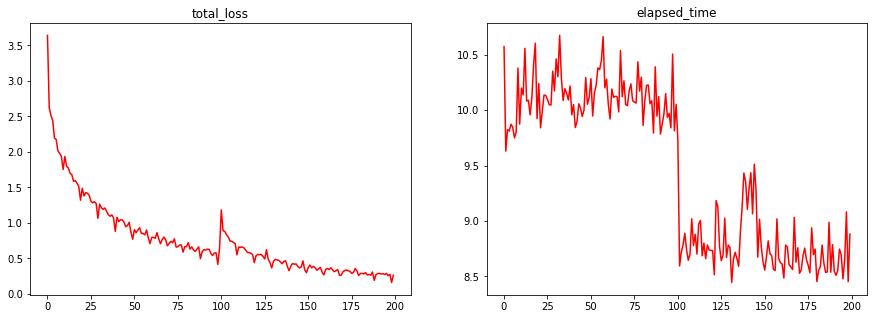

In [33]:
# Load the records
record_df = pd.read_csv(C.record_path)

r_epochs = len(record_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')

plt.show()

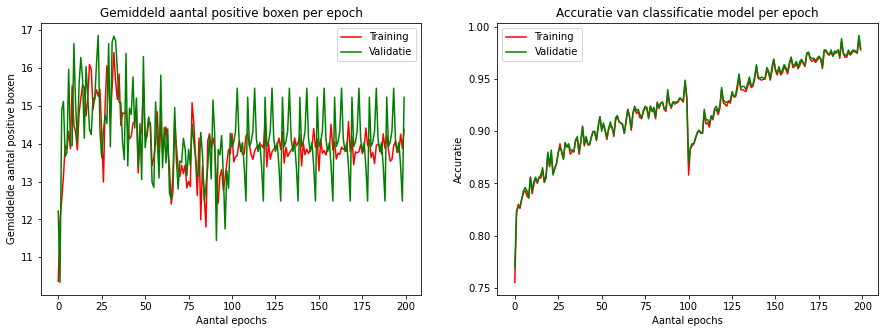

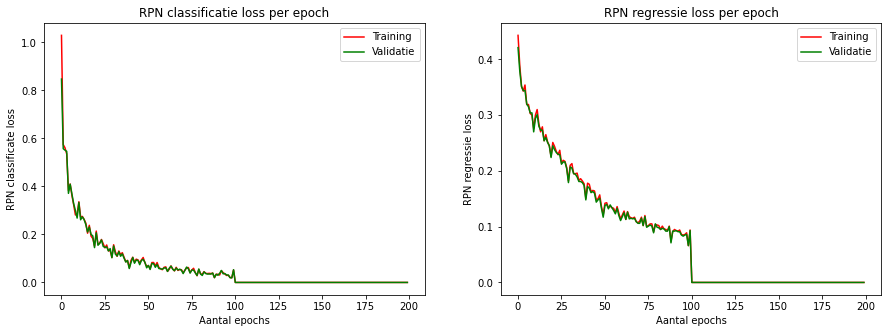

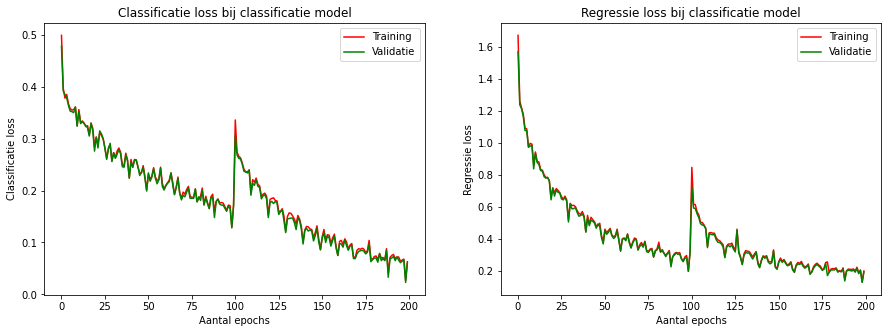

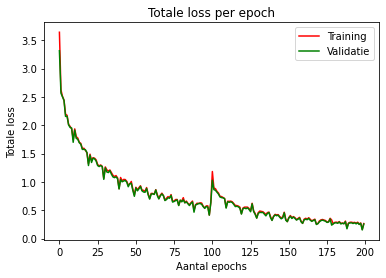

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.xlabel('Aantal epochs')
plt.ylabel('Gemiddelde aantal positive boxen')
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r',label = 'Training')
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes_test'], 'g', label = 'Validatie')
plt.legend()
plt.title('Gemiddeld aantal positive boxen per epoch')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r',label='Training')
plt.plot(np.arange(0, r_epochs), record_df['class_acc_test'], 'g',label = 'Validatie')
plt.xlabel('Aantal epochs')
plt.ylabel('Accuratie')
plt.title('Accuratie van classificatie model per epoch')
plt.legend()

plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.xlabel('Aantal epochs')
plt.ylabel('RPN classificate loss')
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r',label = 'Training')
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls_test'], 'g',label = 'Validatie')
plt.legend()
plt.title('RPN classificatie loss per epoch')
plt.subplot(1,2,2)
plt.xlabel('Aantal epochs')
plt.ylabel('RPN regressie loss')
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r',label = 'Training')
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr_test'], 'g',label = 'Validatie')
plt.legend()
plt.title('RPN regressie loss per epoch')
plt.show()


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r',label = 'Training')
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls_test'], 'g',label = 'Validatie')
plt.legend()
plt.title('Classificatie loss bij classificatie model')
plt.xlabel('Aantal epochs')
plt.ylabel('Classificatie loss')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r',label = 'Training')
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr_test'], 'g',label = 'Validatie')
plt.legend()
plt.title('Regressie loss bij classificatie model')
plt.xlabel('Aantal epochs')
plt.ylabel('Regressie loss')
plt.show()

plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r',label = 'Training')
plt.plot(np.arange(0, r_epochs), record_df['curr_loss_test'], 'g',label = 'Validatie')
plt.legend()
plt.title('Totale loss per epoch')
plt.xlabel('Aantal epochs')
plt.ylabel('Totale loss')
plt.show()

In [35]:
i = 0
plaats = 0
min_loss = 100
for loss in record_df['curr_loss_test']:
    if loss<min_loss:
        min_loss = loss
        plaats = i
    i += 1

    
for row in record_df:
    print(row, record_df[row][plaats])
#     print(record_df[row][28])
#     for getal in record_df[row]:
#         print(getal)
        
    

mean_overlapping_bboxes 13.873
class_acc 0.99
loss_rpn_cls 0.0
loss_rpn_regr 0.0
loss_class_cls 0.027000000000000003
loss_class_regr 0.134
curr_loss 0.162
elapsed_time 8.453
mAP 0.0
mean_overlapping_bboxes_test 12.485
class_acc_test 0.992
loss_rpn_cls_test 0.0
loss_rpn_regr_test 0.0
loss_class_cls_test 0.023
loss_class_regr_test 0.13
curr_loss_test 0.153
elapsed_time_test 0.956
mAP_test 0.0


# Test

In [36]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

In [37]:
num_features = 1024

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)


# define the RPN, built on the base layers
# num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
# rpn_layers = rpn_layer(shared_layers, num_anchors)

model_rpn = tf.keras.models.load_model(model_rpn_path)

model_classifier = tf.keras.models.load_model(model_classifier_path)
model_classifier_only = tf.keras.models.load_model(model_classifier_only_path)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

In [40]:
print(C.model_path)

model_5/model_frcnn_resnet.hdf5


In [44]:
# Switch key value for class mapping
class_mapping = C.class_mapping
print(class_mapping)
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{'huidmond': 0, 'bg': 1}
{0: 'huidmond', 1: 'bg'}


In [45]:
# print(C.model_path)
# print(Config.model_path)

In [46]:
test_imgs = os.listdir(test_base_path)


random.seed(1)
random.shuffle(test_imgs)

imgs_path = []
i=100
for i in range(10):
    idx = np.random.randint(len(test_imgs))
    #print(idx)
    imgs_path.append(test_imgs[idx])

print('imgs_path',imgs_path)

all_imgs = []

classes = {}

imgs_path ['LO_Diospyros bipindensis_Louis 14470_blad1-vak1.jpg', 'RB_Lannea schweinfurthii Bidgood 1759_blad2-vlak2.jpg', 'LB_Strychnos spinosa_Berhaut 131_blad3-vak1.jpg', 'LO_Diospyros bipindensis_Louis 14470_blad2-vak2.jpg', 'RO_Strychnos spinosa_Berhaut 131_blad4-vak1.jpg', 'LB_Diospyros bipindensis_Louis 14470_blad2-vak3.jpg', 'LB_Strychnos cocculoides_Kewensi 6345_blad2-vak3.jpg', 'LO_Lannea welwitschii_Bequaert 7049_blad2-vak1.jpg', 'RB_Diospyros kirkii_Angus 1430_blad3-vak1.jpg', 'RO_Strychnos spinosa_Berhaut 131_blad2-vak1.jpg']


img_name LO_Diospyros bipindensis_Louis 14470_blad1-vak1.jpg
idx 0
filepath ../../data/augmentatie/finale_opdeling/deel_1_training/LO_Diospyros bipindensis_Louis 14470_blad1-vak1.jpg
hight (600, 800, 3)
ratio 1.0
R.shape (300, 4)
R.shape: 300
range(R.shape): range(0, 300)
C.num_rios: 16
range(alles): range(0, 19)
tel_2 19
bboxes {'huidmond': [[608, 480, 736, 608], [288, 336, 448, 480], [656, 288, 800, 432], [672, 288, 800, 432], [288, 336, 448, 480], [608, 480, 736, 608], [80, 80, 224, 224], [288, 336, 448, 480], [368, 96, 512, 240], [288, 336, 464, 480], [288, 336, 448, 480], [672, 288, 800, 448], [64, 80, 224, 224], [64, 64, 208, 208], [288, 336, 448, 480], [368, 96, 512, 240], [80, 80, 224, 224], [64, 64, 208, 224], [656, 288, 800, 448], [288, 336, 448, 480], [352, 96, 512, 240], [608, 480, 752, 608], [656, 288, 784, 432], [608, 496, 736, 608], [352, 96, 496, 240], [368, 96, 512, 256], [304, 336, 464, 480], [288, 336, 448, 480], [64, 64, 224, 240], [288, 336, 448, 480], [672, 288, 8

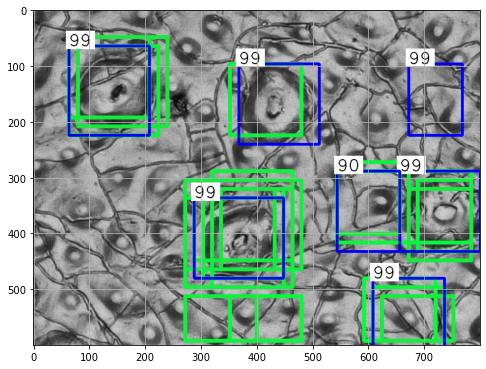

img_name RB_Lannea schweinfurthii Bidgood 1759_blad2-vlak2.jpg
idx 1
filepath ../../data/augmentatie/finale_opdeling/deel_1_training/RB_Lannea schweinfurthii Bidgood 1759_blad2-vlak2.jpg
hight (600, 800, 3)
ratio 1.0
R.shape (300, 4)
R.shape: 300
range(R.shape): range(0, 300)
C.num_rios: 16
range(alles): range(0, 19)
tel_2 19
bboxes {'huidmond': [[112, 496, 256, 608], [0, 368, 80, 480], [320, 64, 464, 192], [240, 256, 384, 400], [608, 224, 752, 368], [256, 256, 384, 384], [608, 208, 752, 336], [448, 0, 592, 112], [448, 0, 592, 96], [384, 464, 528, 608], [64, 0, 208, 128], [576, 416, 736, 560], [576, 416, 736, 560], [416, 304, 576, 448], [128, 176, 272, 320], [416, 320, 560, 448], [592, 224, 736, 352], [416, 320, 576, 448], [240, 256, 384, 400], [576, 432, 736, 576], [384, 464, 528, 608], [576, 432, 720, 560], [0, 368, 64, 496], [128, 176, 272, 304], [416, 320, 560, 448], [384, 448, 528, 592], [416, 304, 576, 448], [608, 208, 752, 336], [384, 448, 528, 592], [320, 80, 448, 208], [576, 4

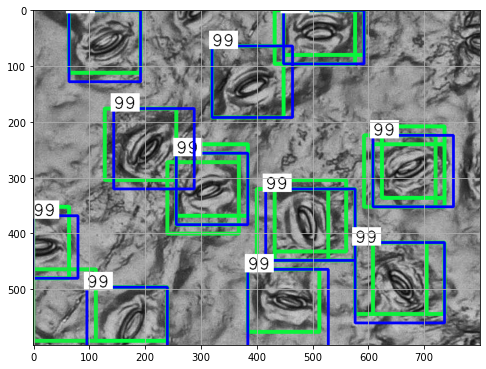

img_name LB_Strychnos spinosa_Berhaut 131_blad3-vak1.jpg
idx 2
filepath ../../data/augmentatie/finale_opdeling/deel_1_training/LB_Strychnos spinosa_Berhaut 131_blad3-vak1.jpg
hight (600, 800, 3)
ratio 1.0
R.shape (300, 4)
R.shape: 300
range(R.shape): range(0, 300)
C.num_rios: 16
range(alles): range(0, 19)
tel_2 19
bboxes {'huidmond': [[432, 496, 592, 608], [432, 496, 592, 608], [432, 480, 592, 608], [128, 128, 288, 272], [432, 496, 592, 624], [144, 112, 304, 256], [528, 176, 688, 320], [272, 272, 416, 432], [528, 176, 688, 320], [64, 400, 208, 560], [288, 272, 448, 432], [64, 416, 208, 560], [528, 176, 672, 320], [64, 416, 224, 560], [144, 128, 304, 272], [288, 272, 416, 432], [528, 176, 688, 336], [128, 128, 272, 272], [528, 176, 688, 336], [64, 416, 224, 560], [272, 272, 432, 448], [288, 272, 432, 448], [64, 416, 208, 560], [432, 496, 592, 624], [288, 272, 432, 448], [64, 416, 208, 560], [48, 416, 208, 560], [528, 160, 688, 320], [272, 272, 416, 448], [512, 176, 672, 336], [128, 128,

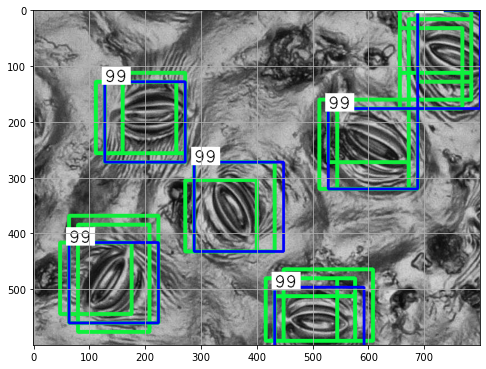

img_name LO_Diospyros bipindensis_Louis 14470_blad2-vak2.jpg
idx 3
filepath ../../data/augmentatie/finale_opdeling/deel_1_training/LO_Diospyros bipindensis_Louis 14470_blad2-vak2.jpg
hight (600, 800, 3)
ratio 1.0
R.shape (300, 4)
R.shape: 300
range(R.shape): range(0, 300)
C.num_rios: 16
range(alles): range(0, 19)
tel_2 19
bboxes {'huidmond': [[448, 0, 592, 144], [432, 0, 592, 160], [608, 256, 752, 400], [448, 16, 608, 160], [624, 256, 752, 400], [608, 240, 736, 384], [624, 256, 768, 400], [432, 16, 576, 160], [608, 256, 752, 400], [432, 0, 592, 160], [448, 16, 592, 176], [432, 16, 576, 160], [448, 16, 592, 160], [608, 256, 752, 384], [448, 16, 592, 160], [448, 16, 592, 160], [448, 16, 592, 160], [768, 496, 784, 544]]}
Elapsed time = 1.2911467552185059
all_dets [('huidmond', 99.99241828918457), ('huidmond', 99.98984336853027), ('huidmond', 94.40832138061523)]
tijdelijke_info {'name': 'LO_Diospyros bipindensis_Louis 14470_blad2-vak2.jpg', 'filepath': '../../data/augmentatie/finale_opdeli

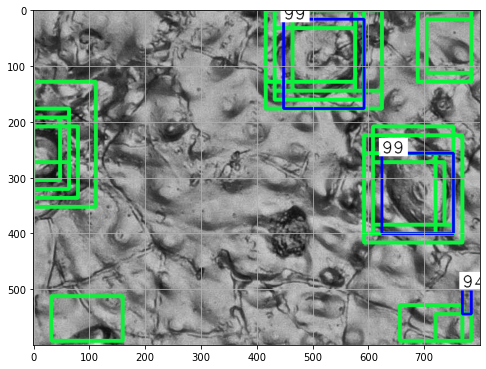

img_name RO_Strychnos spinosa_Berhaut 131_blad4-vak1.jpg
idx 4
filepath ../../data/augmentatie/finale_opdeling/deel_1_training/RO_Strychnos spinosa_Berhaut 131_blad4-vak1.jpg
hight (600, 800, 3)
ratio 1.0
R.shape (300, 4)
R.shape: 300
range(R.shape): range(0, 300)
C.num_rios: 16
range(alles): range(0, 19)
tel_2 19
bboxes {'huidmond': [[32, 496, 176, 608], [32, 496, 176, 608], [384, 0, 544, 112], [688, 144, 784, 304], [368, 0, 528, 128], [384, 0, 544, 112], [608, 400, 784, 560], [272, 288, 432, 432], [608, 416, 768, 560], [608, 400, 752, 544], [272, 288, 448, 448], [64, 0, 224, 160], [48, 0, 224, 160], [48, 0, 208, 160], [608, 416, 752, 560], [256, 288, 432, 432], [608, 400, 768, 560], [48, 16, 208, 160], [48, 0, 208, 160], [256, 288, 448, 448], [368, 0, 528, 128], [48, 0, 224, 144], [48, 0, 224, 160], [256, 288, 416, 448], [256, 288, 432, 432], [704, 144, 800, 288], [272, 288, 448, 448], [592, 400, 768, 544], [16, 496, 208, 608], [48, 0, 224, 160], [368, 0, 528, 112], [384, 0, 528, 128

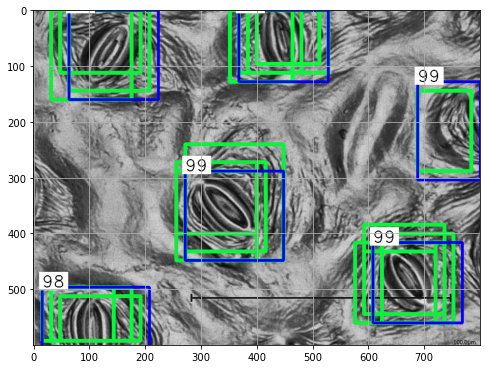

img_name LB_Diospyros bipindensis_Louis 14470_blad2-vak3.jpg
idx 5
filepath ../../data/augmentatie/finale_opdeling/deel_1_training/LB_Diospyros bipindensis_Louis 14470_blad2-vak3.jpg
hight (600, 800, 3)
ratio 1.0
R.shape (300, 4)
R.shape: 300
range(R.shape): range(0, 300)
C.num_rios: 16
range(alles): range(0, 19)
tel_2 19
bboxes {'huidmond': [[368, 256, 544, 416], [352, 240, 544, 400], [368, 256, 544, 416], [384, 256, 544, 400], [368, 240, 528, 400], [144, 96, 272, 224], [368, 256, 528, 416], [384, 256, 544, 400], [160, 80, 304, 224]]}
Elapsed time = 1.2640273571014404
all_dets [('huidmond', 99.99516010284424), ('huidmond', 96.47524952888489)]
tijdelijke_info {'name': 'LB_Diospyros bipindensis_Louis 14470_blad2-vak3.jpg', 'filepath': '../../data/augmentatie/finale_opdeling/deel_1_training/LB_Diospyros bipindensis_Louis 14470_blad2-vak3.jpg', 'width': 800, 'hight': 600, 'bboxen': [{'class': 'huidmond', 'x1': 384, 'x2': 544, 'y1': 256, 'y2': 400, 'prob': 99.99516010284424}, {'class': 'hu

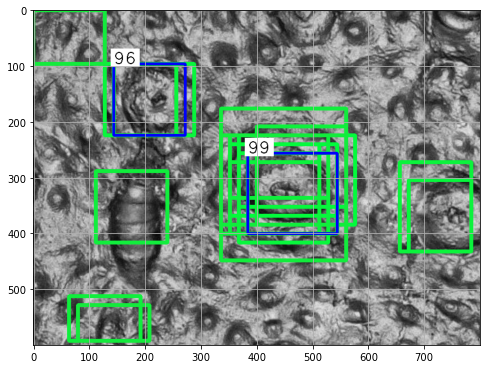

img_name LB_Strychnos cocculoides_Kewensi 6345_blad2-vak3.jpg
idx 6
filepath ../../data/augmentatie/finale_opdeling/deel_1_training/LB_Strychnos cocculoides_Kewensi 6345_blad2-vak3.jpg
hight (600, 800, 3)
ratio 1.0
R.shape (300, 4)
R.shape: 300
range(R.shape): range(0, 300)
C.num_rios: 16
range(alles): range(0, 19)
tel_2 19
bboxes {'huidmond': [[48, 0, 192, 160], [48, 0, 192, 144], [32, 0, 176, 144], [32, 0, 192, 144], [48, 16, 176, 144], [720, 400, 800, 528], [208, 0, 336, 128], [48, 0, 192, 144], [32, 0, 192, 144], [32, 0, 176, 144], [720, 400, 800, 528], [736, 400, 800, 528], [48, 0, 176, 144], [720, 400, 800, 528]]}
Elapsed time = 1.2870991230010986
all_dets [('huidmond', 99.99758005142212), ('huidmond', 99.96498823165894), ('huidmond', 99.84422326087952)]
tijdelijke_info {'name': 'LB_Strychnos cocculoides_Kewensi 6345_blad2-vak3.jpg', 'filepath': '../../data/augmentatie/finale_opdeling/deel_1_training/LB_Strychnos cocculoides_Kewensi 6345_blad2-vak3.jpg', 'width': 800, 'hight': 60

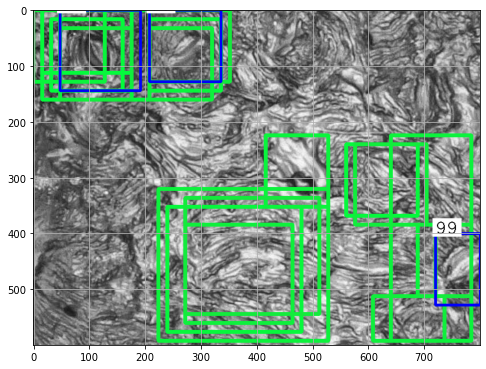

img_name LO_Lannea welwitschii_Bequaert 7049_blad2-vak1.jpg
idx 7
filepath ../../data/augmentatie/finale_opdeling/deel_1_training/LO_Lannea welwitschii_Bequaert 7049_blad2-vak1.jpg
hight (600, 800, 3)
ratio 1.0
R.shape (300, 4)
R.shape: 300
range(R.shape): range(0, 300)
C.num_rios: 16
range(alles): range(0, 19)
tel_2 19
bboxes {'huidmond': [[208, 32, 368, 192], [16, 0, 144, 96], [528, 32, 672, 176], [528, 32, 672, 192], [368, 240, 512, 384], [208, 32, 352, 160], [528, 16, 672, 192], [208, 16, 384, 192], [16, 0, 144, 96], [208, 32, 368, 176], [384, 240, 512, 384], [208, 16, 368, 176], [528, 32, 672, 192], [736, 112, 800, 224], [16, 0, 160, 96], [368, 256, 512, 400], [368, 240, 512, 384], [528, 32, 672, 176], [528, 32, 672, 176], [208, 48, 368, 176], [224, 48, 368, 176], [720, 112, 800, 240], [224, 32, 368, 176], [528, 32, 672, 192]]}
Elapsed time = 1.2413344383239746
all_dets [('huidmond', 99.99921321868896), ('huidmond', 99.98262524604797), ('huidmond', 99.94173049926758), ('huidmond',

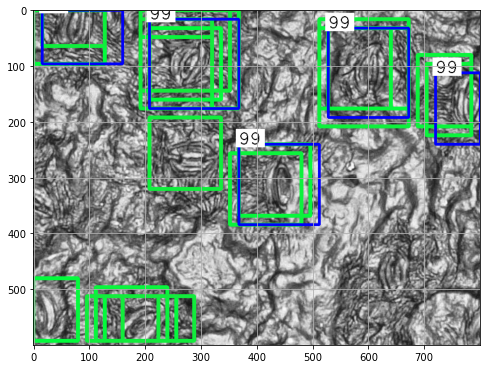

img_name RB_Diospyros kirkii_Angus 1430_blad3-vak1.jpg
idx 8
filepath ../../data/augmentatie/finale_opdeling/deel_1_training/RB_Diospyros kirkii_Angus 1430_blad3-vak1.jpg
hight (600, 800, 3)
ratio 1.0
R.shape (300, 4)
R.shape: 300
range(R.shape): range(0, 300)
C.num_rios: 16
range(alles): range(0, 19)
tel_2 19
bboxes {'huidmond': [[416, 160, 560, 304], [416, 176, 560, 288], [192, 176, 336, 304], [432, 176, 576, 304], [416, 160, 560, 304], [192, 160, 336, 304], [448, 160, 592, 304], [432, 176, 560, 304], [432, 176, 560, 304], [432, 160, 560, 320], [432, 160, 560, 304], [576, 272, 688, 384], [416, 384, 560, 528]]}
Elapsed time = 1.303821086883545
all_dets [('huidmond', 99.99243021011353), ('huidmond', 99.3181049823761), ('huidmond', 90.83797335624695), ('huidmond', 90.38708806037903)]
tijdelijke_info {'name': 'RB_Diospyros kirkii_Angus 1430_blad3-vak1.jpg', 'filepath': '../../data/augmentatie/finale_opdeling/deel_1_training/RB_Diospyros kirkii_Angus 1430_blad3-vak1.jpg', 'width': 800, 'h

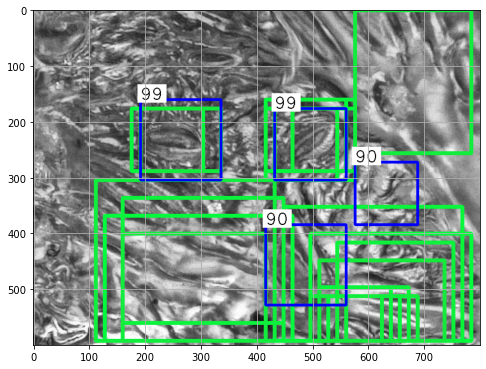

img_name RO_Strychnos spinosa_Berhaut 131_blad2-vak1.jpg
idx 9
filepath ../../data/augmentatie/finale_opdeling/deel_1_training/RO_Strychnos spinosa_Berhaut 131_blad2-vak1.jpg
hight (600, 800, 3)
ratio 1.0
R.shape (300, 4)
R.shape: 300
range(R.shape): range(0, 300)
C.num_rios: 16
range(alles): range(0, 19)
tel_2 19
bboxes {'huidmond': [[160, 496, 304, 608], [688, 368, 800, 512], [160, 256, 320, 400], [96, 0, 256, 112], [176, 496, 304, 608], [320, 240, 464, 384], [688, 384, 800, 512], [528, 368, 672, 512], [160, 256, 320, 400], [560, 128, 704, 288], [528, 352, 672, 512], [320, 240, 464, 384], [544, 128, 704, 304], [160, 240, 320, 400], [320, 240, 464, 384], [560, 128, 720, 304], [560, 128, 704, 288], [432, 96, 592, 272], [160, 256, 304, 416], [544, 112, 704, 288], [160, 240, 304, 400], [432, 96, 576, 256], [528, 368, 672, 512], [160, 240, 304, 416], [528, 368, 672, 512], [96, 0, 240, 128], [528, 368, 672, 512], [96, 0, 240, 128], [432, 96, 576, 256], [160, 256, 304, 400], [528, 368, 656,

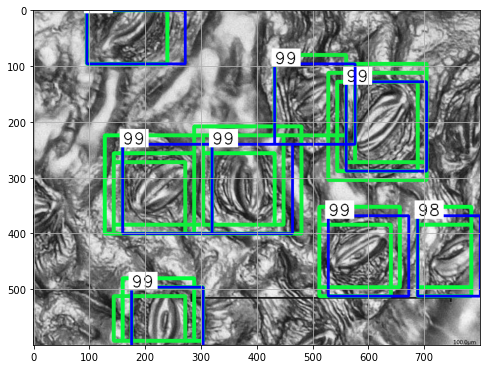

alle_info [{'name': 'LO_Diospyros bipindensis_Louis 14470_blad1-vak1.jpg', 'filepath': '../../data/augmentatie/finale_opdeling/deel_1_training/LO_Diospyros bipindensis_Louis 14470_blad1-vak1.jpg', 'width': 800, 'hight': 600, 'bboxen': [{'class': 'huidmond', 'x1': 288, 'x2': 448, 'y1': 336, 'y2': 480, 'prob': 99.99996423721313}, {'class': 'huidmond', 'x1': 64, 'x2': 208, 'y1': 64, 'y2': 224, 'prob': 99.9953031539917}, {'class': 'huidmond', 'x1': 656, 'x2': 800, 'y1': 288, 'y2': 432, 'prob': 99.98588562011719}, {'class': 'huidmond', 'x1': 368, 'x2': 512, 'y1': 96, 'y2': 240, 'prob': 99.93973970413208}, {'class': 'huidmond', 'x1': 672, 'x2': 768, 'y1': 96, 'y2': 224, 'prob': 99.76280331611633}, {'class': 'huidmond', 'x1': 608, 'x2': 736, 'y1': 480, 'y2': 608, 'prob': 99.64104294776917}, {'class': 'huidmond', 'x1': 544, 'x2': 656, 'y1': 288, 'y2': 432, 'prob': 90.59998989105225}]}, {'name': 'RB_Lannea schweinfurthii Bidgood 1759_blad2-vlak2.jpg', 'filepath': '../../data/augmentatie/finale_

In [47]:
# If the box classification value is less than this, we ignore this box
bbox_threshold = 0.9
print_rpn_boxes = True
print_boxes = True
alle_info = []

for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print('img_name',img_name)
    print('idx',idx)
    tijdelijke_info = {}
    st = time.time()
    filepath = os.path.join(test_base_path, img_name)
    print('filepath',filepath)
    img = cv2.imread(filepath)
    tijdelijke_info['name'] = img_name
    tijdelijke_info['filepath'] = filepath
    tijdelijke_info['width'] = img.shape[1]
    tijdelijke_info['hight'] = img.shape[0]
    print('hight',img.shape)
    X, ratio = format_img(img, C)
#     print('x',X)
    print('ratio',ratio)
    ratio = ratio
    
    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)
    
    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, 'tf', overlap_thresh=0.7)
    print('R.shape',R.shape)
    grootste_x = 0
    grootste_y = 0
    tel=0
   
    if(print_rpn_boxes == True):
        aantal_boxen = 0
        for co in R:
            if aantal_boxen<20:
                (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio*0.0625, co[0], co[1], co[2], co[3])
                #print('real_x1',real_x1)
                #print('real_x2',real_x2)
                #print('co[2]',co[2])
        #         if grootste_x < co[2]:
        #             grootste_x=co[2]
        #         if grootste_y < co[3]:
        #             grootste_y=co[3]
                tel+=1
                #print('co',co)
                #print('class_to_color',class_to_color)
                #print('int(class_to_color[huidmondje][0])',class_to_color['huidmond'][0])
                kleur_1=0
                kleur_2=0
                kleur_3=60
                kleur_1 = 254-tel
                kleur_2 = tel
                if kleur_1<0:
                    kleur_1 = 0
                    kleur_2 = 254
                    kleur_3 = tel-200

                cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (kleur_3, kleur_1, kleur_2),6)
            aantal_boxen += 1
    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]
    
    
    
    tel_2 = 0
    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}
    
    print('R.shape:',R.shape[0])    
    print('range(R.shape):',range(R.shape[0]))
    print('C.num_rios:',C.num_rois)
    print('range(alles):',range(R.shape[0]//C.num_rois + 1))
    
    # R.shape[0] = (0,300)
    # C.num_rios = 4
    # 300/4 = 75 -> 75+1=76
    # Dus hier zal een for lus 76 keer ittereren
    # num_rios = 4 dit betekent dat we 4 rios gaan bekijken tegelijk
    
    for jk in range(R.shape[0]//C.num_rois + 1):
        tel_2 +=1
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        # ROIs.shape[1] is normaal gelijk aan 4
        if ROIs.shape[1] == 0:
            break
        
        #print('jk',jk)
        #print('R.shape[0]//C.num_rois: ',R.shape[0]//C.num_rois)
        
        # hierin komen we nooit DIT doet ook niets
        # Hier zal jk optellen van 0 tot 74
        #  R.shape[0]//C.num_rois = 75    dit is constant het geval
        if jk == R.shape[0]//C.num_rois:
            
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded
        
#         print('F.shape',F.shape)
#         print('RIO.shape',ROIs.shape)
        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])
        
        #print('P_cls: ',P_cls)
        #print('P_regr: ',P_regr)
        
        # P_cls.shape[1]=4
        
        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            #print('P_cls[0, ii, :]: ',P_cls[0, ii, :])
            
            #P_cls[0, ii, :]:  [0.00348739 0.9965126 ]
            #P_cls[0, ii, :]:  [0.03592544 0.9640745 ]
                            #  [% kan dat dit een huidmondje is, % kans dat het background (bg) is ]
                            #  [X,Y] hier is X+Y=100%
            #P_cls[0, ii, :]:   geeft dus voorspellingen
            # FOR IF CONTINUE: Wanneer het if statement true is 
            # zal er overgegaan worden naar de volgende itteratie van de for lus
            # DUS om door te gaan moet het if statement False zijn
            #print('tel_2: ',tel_2)
            
            #Stop als het voorspeelde % te laag is
            if np.max(P_cls[0, ii, :]) < bbox_threshold:
                continue
                
            # We zullen hier stoppen als de kans op huidsel<50%
#             if P_cls[0, ii, :][0] < 0.5:
#                 continue
            
            # np.argmax(P_cls[0, ii, :])=1
            # argmax zal de index teruggeven van het hoogste getal
            # Dus als dit 1 is dan betekent dat in [x,y] nu y het grootste getal zal zijn
            
            # P_cls.shape[2] - 1 = 1
            # Deze zijn vaak hetzelfde. Dan wordt er dus niet doorgegaan
             
            if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue
#             print('tel_2: ',tel_2)
#             print('P_cls[0, ii, :]: ',P_cls[0, ii, :])                              
# #             print(P_cls[0, ii, :])
#             print('np.arg',np.argmax(P_cls[0, ii, :]))
            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]
#             print('KKKK')
#             print('cls_name: ',cls_name)
            
            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))
    print('tel_2',tel_2)
    all_dets = []
    print('bboxes',bboxes)
    tijdelijke_info['bboxen'] = []
    for key in bboxes:
        bbox = np.array(bboxes[key])
        #print('t')
        #print(bbox)
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
#         print('new_boxes',new_boxes)
        
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
#             print(real_x1, real_y1, real_x2, real_y2)
            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (250,0,0),4) # (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

            textLabel = '{}'.format(int(100*new_probs[jk])) #'{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))
            #print('test')
            

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)
            
            tijdelijke_info['bboxen'].append({'class':key,'x1':real_x1,'x2':real_x2,'y1':real_y1,'y2':real_y2,'prob':100*new_probs[jk]})
            
    print('Elapsed time = {}'.format(time.time() - st))
    print('all_dets',all_dets)
    plt.figure(figsize=(8,8))
    plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    print('tijdelijke_info',tijdelijke_info)
    plt.show()
    alle_info.append(tijdelijke_info)
print('alle_info',alle_info)

In [ ]:
test_imgs_volledig, _, _ = get_data(test_path)

In [ ]:
# random.seed(1)
# random.shuffle(test_imgs_volledig)

In [ ]:
test_imgs = test_imgs_volledig
# print('len test_imgs',len(test_imgs))
test_imgs = test_imgs[:len(test_imgs)]
print('len B',len(test_imgs))

In [ ]:
imgs_path = []
i = 100
for i in range(20):
    idx = np.random.randint(len(test_imgs))
    #print(idx)
    imgs_path.append(test_imgs[idx])

# print('imgs_path',imgs_path)

all_imgs = []

classes = {}

In [ ]:
# If the box classification value is less than this, we ignore this box
bbox_threshold = 0.9
print_rpn_boxes = True
print_boxes = True

for idx, img_name in enumerate(imgs_path):
    if not img_name['filepath'].endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = img_name['filepath'] # os.path.join(test_base_path, img_name)
    print(filepath)
    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    #print(X)
    print('ratio',ratio)
    ratio = ratio
    
    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)
    
    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, 'tf', overlap_thresh=0.7)
    print('R.shape',R.shape)
    grootste_x = 0
    grootste_y = 0
    tel=0
    if(print_boxes == True):
        aantal_boxen = 0
        for co in img_name['bboxes']:
            x1 = co['x1']
            x2 = co['x2']
            y1 = co['y1']
            y2 = co['y2']            
            cv2.rectangle(img,(x1, y1), (x2, y2), (0, 0, 255),6)
#             aantal_boxen += 1
            
    if(print_rpn_boxes == True):
        aantal_boxen = 0
        for co in R:
            if aantal_boxen<20:
                (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio*0.0625, co[0], co[1], co[2], co[3])
                cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (0, 255, 0),6)
            aantal_boxen += 1
    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]
    
    
    
    tel_2 = 0
    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}
    
#     print('R.shape:',R.shape[0])    
#     print('range(R.shape):',range(R.shape[0]))
#     print('C.num_rios:',C.num_rois)
#     print('range(alles):',range(R.shape[0]//C.num_rois + 1))
    
    # R.shape[0] = (0,300)
    # C.num_rios = 4
    # 300/4 = 75 -> 75+1=76
    # Dus hier zal een for lus 76 keer ittereren
    # num_rios = 4 dit betekent dat we 4 rios gaan bekijken tegelijk
    
    for jk in range(R.shape[0]//C.num_rois + 1):
        tel_2 +=1
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        # ROIs.shape[1] is normaal gelijk aan 4
        if ROIs.shape[1] == 0:
            break
        
        #print('jk',jk)
        #print('R.shape[0]//C.num_rois: ',R.shape[0]//C.num_rois)
        
        # hierin komen we nooit DIT doet ook niets
        # Hier zal jk optellen van 0 tot 74
        #  R.shape[0]//C.num_rois = 75    dit is constant het geval
        if jk == R.shape[0]//C.num_rois:
            
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded
        
#         print('F.shape',F.shape)
#         print('RIO.shape',ROIs.shape)
        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])
        
        #print('P_cls: ',P_cls)
        #print('P_regr: ',P_regr)
        
        # P_cls.shape[1]=4
        
        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            #print('P_cls[0, ii, :]: ',P_cls[0, ii, :])
            
            #P_cls[0, ii, :]:  [0.00348739 0.9965126 ]
            #P_cls[0, ii, :]:  [0.03592544 0.9640745 ]
                            #  [% kan dat dit een huidmondje is, % kans dat het background (bg) is ]
                            #  [X,Y] hier is X+Y=100%
            #P_cls[0, ii, :]:   geeft dus voorspellingen
            # FOR IF CONTINUE: Wanneer het if statement true is 
            # zal er overgegaan worden naar de volgende itteratie van de for lus
            # DUS om door te gaan moet het if statement False zijn
            #print('tel_2: ',tel_2)
            
            #Stop als het voorspeelde % te laag is
            if np.max(P_cls[0, ii, :]) < bbox_threshold:
                continue
                
            # We zullen hier stoppen als de kans op huidsel<50%
            if P_cls[0, ii, :][0] < 0.5:
                continue
            
            # np.argmax(P_cls[0, ii, :])=1
            # argmax zal de index teruggeven van het hoogste getal
            # Dus als dit 1 is dan betekent dat in [x,y] nu y het grootste getal zal zijn
            
            # P_cls.shape[2] - 1 = 1
            # Deze zijn vaak hetzelfde. Dan wordt er dus niet doorgegaan
             
            if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue
#             print('tel_2: ',tel_2)
#             print('P_cls[0, ii, :]: ',P_cls[0, ii, :])                              
# #             print(P_cls[0, ii, :])
#             print('np.arg',np.argmax(P_cls[0, ii, :]))
            cls_name = class_mapping[0] #np.argmax(P_cls[0, ii, :])]
#             print('KKKK')
#             print('cls_name: ',cls_name)
            
            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))
    print('tel_2',tel_2)
    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])
        #print('t')
        #print(bbox)
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
#         print('new_boxes',new_boxes)
        
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
#             print(real_x1, real_y1, real_x2, real_y2)
            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (250,0,0),4) # (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

            textLabel = '{}'.format(int(100*new_probs[jk])) #'{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))
            #print('test')

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(8,8))
    plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

#### Measure mAP

In [ ]:
def get_map(pred, gt, f):
	T = {}
	P = {}
	fx, fy = f
	# fx,fy gaat over de soort: Dus is hier altijd 1 want huidmondje is 1
    
	# Begin met alles false te zetten
	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array([s['prob'] for s in pred])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for gt_box in gt:
			gt_class = gt_box['class']
# 			gt_x1 = gt_box['x1']/fx
# 			gt_x2 = gt_box['x2']/fx
# 			gt_y1 = gt_box['y1']/fy
# 			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			if gt_box['x1']<0:
				gt_box['x1'] = 0      
			if gt_box['y1']<0:
				gt_box['y1'] = 0  
			gt_x = (gt_box['x2']+gt_box['x1'])/2
			gt_y = (gt_box['y2']+gt_box['y1'])/2
            
            
			if pred_x1<0:
				pred_x1 = 0      
			if pred_y1<0:
				pred_y1 = 0  
			pred_x = (pred_x2+pred_x1)/2
			pred_y = (pred_y2+pred_y1)/2
			procent_naast_x = (gt_box['x2']-gt_box['x1'])*0.2
			procent_naast_y = (gt_box['y2']-gt_box['y1'])*0.2
			voorspeld_naast_x = abs(pred_x-gt_x)
			voorspeld_naast_y = abs(pred_y-gt_y)
			if voorspeld_naast_x<procent_naast_x and voorspeld_naast_y<procent_naast_y:
				found_match = True
				gt_box['bbox_matched'] = True
        
            
# 			iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
# 			if iou_map >= 0.5:
# 				found_match = True
# 				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))

	for gt_box in gt:
		if not gt_box['bbox_matched']:# and not gt_box['difficult']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []

			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)

	#import pdb
	#pdb.set_trace()
	return T, P

In [ ]:
def get_map_origineel(pred, gt, f):
	T = {}
	P = {}
	fx, fy = f
	# fx,fy gaat over de soort: Dus is hier altijd 1 want huidmondje is 1
    
	# Begin met alles false te zetten
	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array([s['prob'] for s in pred])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']/fx
			gt_x2 = gt_box['x2']/fx
			gt_y1 = gt_box['y1']/fy
			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			if iou_map >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))

	for gt_box in gt:
		if not gt_box['bbox_matched']:# and not gt_box['difficult']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []

			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)

	#import pdb
	#pdb.set_trace()
	return T, P

In [ ]:
def format_img_map(img, C):
	"""Format image for mAP. Resize original image to C.im_size (300 in here)

	Args:
		img: cv2 image
		C: config

	Returns:
		img: Scaled and normalized image with expanding dimension
		fx: ratio for width scaling
		fy: ratio for height scaling
	"""

	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
	
	if width <= height:
		f = img_min_side/width
		new_height = int(f * height)
		new_width = int(img_min_side)
	else:
		f = img_min_side/height
		new_width = int(f * width)
		new_height = int(img_min_side)
	fx = width/float(new_width)
	fy = height/float(new_height)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	# Change image channel from BGR to RGB
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	# Change img shape from (height, width, channel) to (channel, height, width)
	img = np.transpose(img, (2, 0, 1))
	# Expand one dimension at axis 0
	# img shape becames (1, channel, height, width)
	img = np.expand_dims(img, axis=0)
	return img, fx, fy

In [ ]:
print(class_mapping)

In [ ]:
# This might takes a while to parser the data
test_imgs_volledig, _, _ = get_data(test_path)

In [ ]:
random.seed(1)
random.shuffle(test_imgs_volledig)

In [ ]:
test_imgs = copy.deepcopy(test_imgs_volledig)
# print('len test_imgs',len(test_imgs))
test_imgs = test_imgs[:len(test_imgs)]
print('len B',len(test_imgs))

In [ ]:
test_imgs = test_imgs[:2500]
print('len B',len(test_imgs))

In [ ]:
all_imgs = {}
extra_all_imgs = {}
test_imgs_all = test_imgs
for namen in test_imgs_all:
#     print(namen['filepath'])
    naam = namen['filepath'].split('.')
#     print('naam',naam)
#     print('naam',naam[-2])
    deel_naam = naam[-2].split('/')
#     print('deel_naam:',deel_naam[-1])
    e_naam = deel_naam[-1].split('_')
#     print(e_naam)
    plaats = 0
    opslag = 0
    for deel in e_naam:
        if len(deel)>5 and opslag == 0:
            uiteindelijke_plaats = plaats
            opslag = 1
        plaats+=1
#     print(e_naam[uiteindelijke_plaats])
    filename = e_naam[uiteindelijke_plaats]
    if filename not in all_imgs:            
        all_imgs[filename] = []  
        
    if filename not in extra_all_imgs:
        extra_all_imgs[filename] = []
        

    all_imgs[filename].append(namen)
# print('all',all_imgs)
# print(test_imgs['filepath'])

In [ ]:
# !!!!!!!!!!!!!!!!!! LEES COMMENT !!!!!!!!!!
# Hier gebeurd not is hetzelfde als bij TEST maar nu wordt de mAP berekent
# Als het hier niet werkt dan kan het zijn de er bij TEST aanpassingen zijn gemaakt
# Die hier nog niet zijn doorgevoert.
# KIJK dit na
afbeelden_recall_precision = True
tel_aantal = 0
print_boxes = True
toon_bboxen = True
pre_all = []
rec_all = []
for sleutel in all_imgs:
#     for test_imgs in all_imgs[sleutel]:
    print('x')
    T = {}
    P = {}
    test_imgs = all_imgs[sleutel]
    print('soort: ',sleutel)
#     print('test_imgs',test_imgs)
#     print('x')
#     print('x')
#     print('x')
#     print('all_imgs_sleutel',all_imgs[sleutel])
    mAPs = []
    for idx, img_data in enumerate(test_imgs):
        tel_aantal += 1
        print('{}/{}'.format(idx,len(test_imgs)))
        st = time.time()
        if len(test_imgs)>1:

#             print(img_data)
            filepath = img_data['filepath']

#             print(filepath)
            img = cv2.imread(filepath)

            X, fx, fy = format_img_map(img, C)



            # Change X (img) shape from (1, channel, height, width) to (1, height, width, channel)
            X = np.transpose(X, (0, 2, 3, 1))

            # get the feature maps and output from the RPN
            [Y1, Y2, F] = model_rpn.predict(X)


            R = rpn_to_roi(Y1, Y2, C, 'tf', overlap_thresh=0.7)

            # convert from (x1,y1,x2,y2) to (x,y,w,h)
            R[:, 2] -= R[:, 0]
            R[:, 3] -= R[:, 1]

            # apply the spatial pyramid pooling to the proposed regions
            bboxes = {}
            probs = {}

            for jk in range(R.shape[0] // C.num_rois + 1):
                ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
                if ROIs.shape[1] == 0:
                    break

                if jk == R.shape[0] // C.num_rois:
                    # pad R
                    curr_shape = ROIs.shape
                    target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
                    ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
                    ROIs_padded[:, :curr_shape[1], :] = ROIs
                    ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
                    ROIs = ROIs_padded

                [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

                # Calculate all classes' bboxes coordinates on resized image (300, 400)
                # Drop 'bg' classes bboxes
                for ii in range(P_cls.shape[1]):

                    # If class name is 'bg', continue
                    if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                        continue

                    # Get class name
                    cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

                    if cls_name not in bboxes:
                        bboxes[cls_name] = []
                        probs[cls_name] = []

                    (x, y, w, h) = ROIs[0, ii, :]

                    cls_num = np.argmax(P_cls[0, ii, :])
                    try:
                        (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]
                        tx /= C.classifier_regr_std[0]
                        ty /= C.classifier_regr_std[1]
                        tw /= C.classifier_regr_std[2]
                        th /= C.classifier_regr_std[3]                
                        x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
                    except:
                        pass
                    bboxes[cls_name].append([16 * x, 16 * y, 16 * (x + w), 16 * (y + h)])
                    probs[cls_name].append(np.max(P_cls[0, ii, :]))

            all_dets = []

            for key in bboxes:
                bbox = np.array(bboxes[key])

                # Apply non-max-suppression on final bboxes to get the output bounding boxe
                new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
                for jk in range(new_boxes.shape[0]):
                    (x1, y1, x2, y2) = new_boxes[jk, :]
                    det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
                    all_dets.append(det)


            print('Elapsed time = {}'.format(time.time() - st))
#             print('all_dets',all_dets)
#             print('img_data[bboxes]',img_data['bboxes'])
#             print('(fx, fy)',(fx, fy))
            t, p = get_map(all_dets, img_data['bboxes'], (fx, fy))
            for key in t.keys():
                if key not in T:
                    T[key] = []
                    P[key] = []
                T[key].extend(t[key])
                P[key].extend(p[key])
            all_aps = []
#             print('T',T)
#             print('P',P)
            for key in T.keys():
                ap = average_precision_score(T[key], P[key])
                print('{} AP: {}'.format(key, ap))
                all_aps.append(ap)
            print('mAP = {}'.format(np.mean(np.array(all_aps))))
            mAPs.append(np.mean(np.array(all_aps)))
            #print(T)
            #print(P)
            extra_all_imgs[sleutel] = {}
            precision = []
            recall = []
            threshold = []
            extra_all_imgs[sleutel]['precision'] = []
            extra_all_imgs[sleutel]['recall'] = []
            extra_all_imgs[sleutel]['threshold'] = []
            precision = dict()
            recall = dict()    
            threshold = dict()
            average_precision = dict()
            extra_all_imgs[sleutel]['precision'] = dict()
            extra_all_imgs[sleutel]['recall'] = dict()
            extra_all_imgs[sleutel]['threshold'] = dict()
            for key in T.keys():
        #         ap = average_precision_score(T[key], P[key])
                precision[key], recall[key], threshold[key] = precision_recall_curve(T[key], P[key])
                extra_all_imgs[sleutel]['precision'][key], extra_all_imgs[sleutel]['recall'][key], extra_all_imgs[sleutel]['threshold'][key] = precision_recall_curve(T[key], P[key])
#                 print('precision_key:',precision[key])
#                 print('threshold_key',threshold)
#                 print('recall_key:',recall[key])
                average_precision[key] = average_precision_score(T[key], P[key])

#             print('precision:',precision['huidmond'])
#             print('recall:',recall)

        ### DIT ZELF TOEGEVOEGD ###
            if idx%10 == 0 or idx == 0:
                if(print_boxes == True):
                    aantal_boxen = 0
                    for co in img_data['bboxes']:
                        x1 = co['x1']
                        x2 = co['x2']
                        y1 = co['y1']
                        y2 = co['y2']            
                        cv2.rectangle(img,(x1, y1), (x2, y2), (0, 0, 255),6)
                if toon_bboxen == True:
                    for key in bboxes:
                        bbox = np.array(bboxes[key])
                        #print('t')
                #         print(bbox)
                        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
                #         print('new_boxes',new_boxes)

                        for jk in range(new_boxes.shape[0]):
                            (x1, y1, x2, y2) = new_boxes[jk,:]

                            # Calculate real coordinates on original image
                            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
                #             print(real_x1, real_y1, real_x2, real_y2)
                            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (250,0,0),4) # (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

                            textLabel = '{}'.format(int(100*new_probs[jk])) #'{}: {}'.format(key,int(100*new_probs[jk]))
                            all_dets.append((key,100*new_probs[jk]))
                            #print('test')

                            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
                            textOrg = (real_x1, real_y1-0)

                            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
                            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
                            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

                    plt.figure(figsize=(8,8))
                    plt.grid()
                    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
                    plt.show()

        ### TOT HIER ###  
            if afbeelden_recall_precision == True:

                if tel_aantal == len(test_imgs): 
                    plt.figure(figsize = (10,10))

                    plt.xlabel('Recall')
                    plt.ylabel('Precision')
                    plt.ylim([0.0, 1.05])
                    plt.xlim([0.0, 1.05])
            #         precision['huidmond'].sort()
                #     print('precision:',precision['huidmond'])
                #     print('recall:',recall['huidmond'])
                    plt.plot(recall['huidmond'],precision['huidmond'])
                #     plt.title(
                #         'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
                #         .format(average_precision["micro"]))
                    plt.show()
#                 if tel_aantal%20 == 0:  
#                     print('tel_aantal',tel_aantal)
#                     print('tel_aantal20',tel_aantal%20)
#                     print('precision:',precision['huidmond'])
#                     print('recall:',recall['huidmond'])
#                     print('threshold',threshold)
#         print()
        print('mean average precision:', np.mean(np.array(mAPs)))
#         print('pppp',precision['huidmond'])
    #     extra_all_imgs[sleutel]['precision'].append(precision['huidmond'])
    #     extra_all_imgs[sleutel]['recall']  = recall['huidmond']
    #     extra_all_imgs[sleutel]['threshold']  = threshold['huidmond']
    #     extra_all_imgs[sleutel]['average_precision']  = average_precision['huidmond']


In [ ]:
extra_all_imgs_back_up = copy.deepcopy(extra_all_imgs)
# print(extra_all_imgs)

In [ ]:
extra_all_imgs = copy.deepcopy(extra_all_imgs_back_up)

In [ ]:
for key in extra_all_imgs:
#     print(extra_all_imgs[key])
    print(key)
    if len(extra_all_imgs[key])>1:
        extra_all_imgs[key]['recall']['huidmond'] = extra_all_imgs[key]['recall']['huidmond'][:-1]
        extra_all_imgs[key]['precision']['huidmond'] = extra_all_imgs[key]['precision']['huidmond'][:-1]
        extra_all_imgs[key]['threshold']['huidmond'] = extra_all_imgs[key]['threshold']['huidmond']
        print(len(extra_all_imgs[key]['recall']['huidmond']))
        print(len(extra_all_imgs[key]['precision']['huidmond']))
        print(len(extra_all_imgs[key]['threshold']['huidmond']))

## Algemeen

In [ ]:
print(extra_all_imgs)

In [ ]:
alles_samen = {}
alles_samen['precision'] = []
alles_samen['recall'] = []
alles_samen['threshold'] = []
nummer = 0
for key in extra_all_imgs:
    if(len(extra_all_imgs[key])>1):
        for prec in extra_all_imgs[key]['precision']['huidmond']:
            alles_samen['precision'].append(prec)
        for rec in extra_all_imgs[key]['recall']['huidmond']:
            alles_samen['recall'].append(rec)
        for thresh in extra_all_imgs[key]['threshold']['huidmond']:
            alles_samen['threshold'].append(thresh)
#     print(nummer)
#     nummer+=1
alles_samen['precision'].sort()
alles_samen['recall'].sort(reverse=True)
alles_samen['threshold'].sort()

In [ ]:
print(len(alles_samen['precision']))
print(len(alles_samen['recall']))
print(len(alles_samen['threshold']))

In [ ]:
print(alles_samen)

In [ ]:
plt.figure(figsize = (8,8))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.plot(alles_samen['recall'],alles_samen['precision'])
#     plt.title(
#         'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
#         .format(average_precision["micro"]))

plt.title('Precision recall curve')
plt.show()
# print(recall['huidmond'])
# print('len',len(recall['huidmond']))

In [ ]:
max_opp = 0
len_prec = len(precision)
i = 0
max_pre = 0
max_rec = 0

while i < len(alles_samen['precision']):
    opp = alles_samen['precision'][i]*alles_samen['recall'][i]
    if opp>max_opp:
        max_opp = opp
        max_pre = alles_samen['precision'][i]
        max_rec = alles_samen['recall'][i]
        max_thres = alles_samen['threshold'][i]
    i+=1
    
print('max oppervlak',max_opp)
print('max precision',max_pre)
print('max recall',max_rec)
print('max_thresh',max_thres)

In [ ]:
i = 0
F1 = []
gem_F1 = 0
max_F1 = 0
index_max_F1 = 0
while i < len(alles_samen['precision']):
    F1_tijdelijk = (2*alles_samen['precision'][i]* alles_samen['recall'][i])/( alles_samen['precision'][i]+ alles_samen['recall'][i])
    gem_F1 = gem_F1+F1_tijdelijk
    F1.append(F1_tijdelijk)
    if max_F1<F1_tijdelijk:
        max_F1 = F1_tijdelijk
        index_max_F1 = i
    i+=1
    
print('len threshold',len(alles_samen['threshold']))
print('len F1',len(F1))
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.ylim([0.0, 1.05])
plt.xlim([0.5, 1.05])
plt.title('F1 score')
plt.plot(alles_samen['threshold'],F1)
# plt.plot(F1)
plt.show()
print('max F1',max(F1))
print('gem F1',gem_F1/i)
# print('i',i)
print('max F1 score',F1[index_max_F1])
print('Threshold van max F1 score', alles_samen['threshold'][index_max_F1])

## Gemiddelde F1 van alle soorten samen

In [ ]:
# alle_max_f1 = []
# totaal_f1 = 0
# aantal_plantsoorten = 0
# for key in extra_all_imgs:
# #     print(extra_all_imgs[key])
#     if len(extra_all_imgs[key])>1:
#         alle_max_f1.append(extra_all_imgs[key]['max_F1'])
#         totaal_f1 += extra_all_imgs[key]['max_F1']
#         aantal_plantsoorten += 1
# # print(alle_max_f1)
# print('totaal_f1',totaal_f1)
# print('aantal_plantsoorten',aantal_plantsoorten)
# print('gemiddelde_f1',totaal_f1/aantal_plantsoorten)

## Per soort

In [ ]:

algemene_threshold =alles_samen['threshold'][index_max_F1]
for key in extra_all_imgs:
#     print(extra_all_imgs[key])
    print(key)
    if len(extra_all_imgs[key])>1:
        plt.figure(figsize = (10,10))
        
        extra_all_imgs[key]['recall']['huidmond'] = extra_all_imgs[key]['recall']['huidmond'][1:]
        extra_all_imgs[key]['precision']['huidmond'] = extra_all_imgs[key]['precision']['huidmond'][1:]
        extra_all_imgs[key]['threshold']['huidmond'] = extra_all_imgs[key]['threshold']['huidmond'][1:]
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.05])
        plt.plot(extra_all_imgs[key]['recall']['huidmond'],extra_all_imgs[key]['precision']['huidmond'])
        plt.show()
        
        max_opp = 0
        len_prec = len(extra_all_imgs[key]['precision'])
        i = 0
        max_pre = 0
        max_rec = 0

        while i < len_prec:
            opp = extra_all_imgs[key]['precision']['huidmond'][i]*extra_all_imgs[key]['recall']['huidmond'][i]
            if opp>max_opp:
                max_opp = opp
                max_pre = extra_all_imgs[key]['precision']['huidmond'][i]
                max_rec = extra_all_imgs[key]['recall']['huidmond'][i]
            i+=1

        print('max oppervlak',max_opp)
        print('max precision',max_pre)
        print('max recall',max_rec)

In [ ]:
for key in extra_all_imgs:
#     print(extra_all_imgs[key])
    print(key)
    if len(extra_all_imgs[key])>1:
        
        
        max_opp = 0
        len_prec = len(extra_all_imgs[key]['precision'])
        i = 0
        max_pre = 0
        max_rec = 0

        while i < len_prec:
            opp = extra_all_imgs[key]['precision']['huidmond'][i]*extra_all_imgs[key]['recall']['huidmond'][i]
            if opp>max_opp:
                max_opp = opp
                max_pre = extra_all_imgs[key]['precision']['huidmond'][i]
                max_rec = extra_all_imgs[key]['recall']['huidmond'][i]
            i+=1

        print('  max oppervlak',max_opp)
        print('  max precision',max_pre)
        print('  max recall',max_rec)

In [ ]:
algemene_threshold = 0.7
grootste = 0
beste_t = 0
while algemene_threshold<1:
    for key in extra_all_imgs:
    #     print(extra_all_imgs[key])
        thresh_aantal = 0
        if len(extra_all_imgs[key])>1:
    #         print(key)

            i = 0
            F1 = []
            gem_F1 = 0
            max_F1 = 0
            index_max_F1 = 0
            while i < len(extra_all_imgs[key]['precision']['huidmond']):
                F1_tijdelijk = (2*extra_all_imgs[key]['precision']['huidmond'][i]*extra_all_imgs[key]['recall']['huidmond'][i])/(extra_all_imgs[key]['precision']['huidmond'][i]+extra_all_imgs[key]['recall']['huidmond'][i])
                gem_F1 = gem_F1+F1_tijdelijk
                F1.append(F1_tijdelijk)
                if max_F1<F1_tijdelijk:
                    max_F1 = F1_tijdelijk
                    index_max_F1 = i
    #             print(len(extra_all_imgs[key]['threshold']['huidmond']))
    #             print('i',i)
                if len(extra_all_imgs[key]['threshold']['huidmond'])>i:
    #                 print('HHHHHHHH')
                    if extra_all_imgs[key]['threshold']['huidmond'][i] > algemene_threshold and thresh_aantal == 0:
                        extra_all_imgs[key]['F1_bij_thresh'] = F1_tijdelijk
                        thresh_aantal = 1

                i+=1
            if thresh_aantal == 0:
                extra_all_imgs[key]['F1_bij_thresh'] = 0
    #         print(F1)
    #         print('  Threshold van max F1 score',extra_all_imgs[key]['threshold']['huidmond'])
            extra_all_imgs[key]['max_F1'] = F1[index_max_F1]
            extra_all_imgs[key]['max_threshold'] = extra_all_imgs[key]['threshold']['huidmond'][index_max_F1]
    #         print('  max F1 score',F1[index_max_F1])
    #         print('  max_F1',extra_all_imgs[key]['max_F1'])
    #         print('  Threshold van max F1 score',extra_all_imgs[key]['threshold']['huidmond'][index_max_F1])
    #         print('  F1 bij gekozen threshold',extra_all_imgs[key]['F1_bij_thresh'])
    alle_max_f1 = []
    totaal_f1 = 0
    aantal_plantsoorten = 0
    for key in extra_all_imgs:
    #     print(extra_all_imgs[key])
        if len(extra_all_imgs[key])>1:
            alle_max_f1.append(extra_all_imgs[key]['F1_bij_thresh'])
            totaal_f1 += extra_all_imgs[key]['F1_bij_thresh']
            aantal_plantsoorten += 1
    # print(alle_max_f1)
    print('algemene_threshold',algemene_threshold)
#     print('totaal_f1',totaal_f1)
#     print('aantal_plantsoorten',aantal_plantsoorten)
    print('    gemiddelde_f1',totaal_f1/aantal_plantsoorten)
    if grootste< (totaal_f1/aantal_plantsoorten):
        grootste = totaal_f1/aantal_plantsoorten
        beste_t = algemene_threshold
    algemene_threshold+=0.001
print(grootste)
print(beste_t)

## F1 bij beste algemene threshold

In [ ]:
algemene_threshold = 0.905
for key in extra_all_imgs:
    #     print(extra_all_imgs[key])
        thresh_aantal = 0
        if len(extra_all_imgs[key])>1:
    #         print(key)

            i = 0
            F1 = []
            gem_F1 = 0
            max_F1 = 0
            index_max_F1 = 0
            while i < len(extra_all_imgs[key]['precision']['huidmond']):
                F1_tijdelijk = (2*extra_all_imgs[key]['precision']['huidmond'][i]*extra_all_imgs[key]['recall']['huidmond'][i])/(extra_all_imgs[key]['precision']['huidmond'][i]+extra_all_imgs[key]['recall']['huidmond'][i])
                gem_F1 = gem_F1+F1_tijdelijk
                F1.append(F1_tijdelijk)
                if max_F1<F1_tijdelijk:
                    max_F1 = F1_tijdelijk
                    index_max_F1 = i
    #             print(len(extra_all_imgs[key]['threshold']['huidmond']))
    #             print('i',i)
                if len(extra_all_imgs[key]['threshold']['huidmond'])>i:
    #                 print('HHHHHHHH')
                    if extra_all_imgs[key]['threshold']['huidmond'][i] > algemene_threshold and thresh_aantal == 0:
                        extra_all_imgs[key]['F1_bij_thresh'] = F1_tijdelijk
                        thresh_aantal = 1

                i+=1
            if thresh_aantal == 0:
                extra_all_imgs[key]['F1_bij_thresh'] = 0
    #         print(F1)
    #         print('  Threshold van max F1 score',extra_all_imgs[key]['threshold']['huidmond'])
            extra_all_imgs[key]['max_F1'] = F1[index_max_F1]
            extra_all_imgs[key]['max_threshold'] = extra_all_imgs[key]['threshold']['huidmond'][index_max_F1]
    #         print('  max F1 score',F1[index_max_F1])
    #         print('  max_F1',extra_all_imgs[key]['max_F1'])
    #         print('  Threshold van max F1 score',extra_all_imgs[key]['threshold']['huidmond'][index_max_F1])
    #         print('  F1 bij gekozen threshold',extra_all_imgs[key]['F1_bij_thresh'])

In [ ]:
algemene_threshold = 0.905
alle_max_f1 = []
totaal_f1 = 0
aantal_plantsoorten = 0
for key in extra_all_imgs:
#     print(extra_all_imgs[key])
    if len(extra_all_imgs[key])>1:
        alle_max_f1.append(extra_all_imgs[key]['F1_bij_thresh'])
        totaal_f1 += extra_all_imgs[key]['F1_bij_thresh']
        aantal_plantsoorten += 1
# print(alle_max_f1)
print('totaal_f1',totaal_f1)
print('aantal_plantsoorten',aantal_plantsoorten)
print('gemiddelde_f1',totaal_f1/aantal_plantsoorten)

In [ ]:
zeer_kleine_f1 = []
kleine_f1 = []
middel_kleine_f1 = []
middel_f1 = []
middel_grootte_f1 = []
grootte_f1 = []
zeer_grootte_f1 = []

In [ ]:
for key in extra_all_imgs:
#     print(extra_all_imgs[key])
    if len(extra_all_imgs[key])>1:
        if extra_all_imgs[key]['max_F1']<0.5:
            zeer_kleine_f1.append([key,extra_all_imgs[key]['max_F1'],extra_all_imgs[key]['max_threshold']])
            
        elif extra_all_imgs[key]['max_F1']<0.8:
            kleine_f1.append([key,extra_all_imgs[key]['max_F1'],extra_all_imgs[key]['max_threshold']])  
            
        elif extra_all_imgs[key]['max_F1']<0.85:
            middel_kleine_f1.append([key,extra_all_imgs[key]['max_F1'],extra_all_imgs[key]['max_threshold']])
        
        elif extra_all_imgs[key]['max_F1']<0.9:
            middel_f1.append([key,extra_all_imgs[key]['max_F1'],extra_all_imgs[key]['max_threshold']])
        
        elif extra_all_imgs[key]['max_F1']<0.95:
            middel_grootte_f1.append([key,extra_all_imgs[key]['max_F1'],extra_all_imgs[key]['max_threshold']])
        
        
        elif extra_all_imgs[key]['max_F1']<0.99:
            grootte_f1.append([key,extra_all_imgs[key]['max_F1'],extra_all_imgs[key]['max_threshold']])
        else:
            zeer_grootte_f1.append([key,extra_all_imgs[key]['max_F1'],extra_all_imgs[key]['max_threshold']])

In [ ]:

print('zeer_klein_f1',len(zeer_kleine_f1))
print('klein_f1',len(kleine_f1))
print('middel_klein_f1',len(middel_kleine_f1))
print('middel_f1',len(middel_f1))
print('middel_groot_f1',len(middel_grootte_f1))
print('groot_f1',len(grootte_f1))
print('zeer_groot_f1',len(zeer_grootte_f1))



In [ ]:
boven_8 = len(middel_kleine_f1) + len(middel_f1) + len(middel_grootte_f1) + len(grootte_f1) + len(zeer_grootte_f1)
print('onder 0.5:',len(zeer_kleine_f1))
print('tussen 0.5 en 0.8:',len(kleine_f1))
print('boven 0.8:',boven_8)


In [ ]:
array_met_f1_scores = []
for key in extra_all_imgs:
#     print(extra_all_imgs[key])
    thresh_aantal = 0
    if len(extra_all_imgs[key])>1:
#         print(key)
#         print(extra_all_imgs[key]['max_F1'])
        array_met_f1_scores.append([key,extra_all_imgs[key]['max_F1']])
print('array_met_f1_scores =', array_met_f1_scores)
print(len(array_met_f1_scores))

## Bij gegeven threshold

In [ ]:
zeer_kleine_f1_t = []
kleine_f1_t = []
middel_kleine_f1_t = []
middel_f1_t = []
middel_grootte_f1_t = []
grootte_f1_t = []
zeer_grootte_f1_t = []

In [ ]:
for key in extra_all_imgs:
#     print(extra_all_imgs[key])
    if len(extra_all_imgs[key])>1:
        if extra_all_imgs[key]['F1_bij_thresh']<0.5:
            zeer_kleine_f1_t.append([key,extra_all_imgs[key]['F1_bij_thresh'],extra_all_imgs[key]['max_threshold']])
            
        elif extra_all_imgs[key]['F1_bij_thresh']<0.8:
            kleine_f1_t.append([key,extra_all_imgs[key]['F1_bij_thresh'],extra_all_imgs[key]['max_threshold']])  
            
        elif extra_all_imgs[key]['F1_bij_thresh']<0.85:
            middel_kleine_f1_t.append([key,extra_all_imgs[key]['F1_bij_thresh'],extra_all_imgs[key]['max_threshold']])
        
        elif extra_all_imgs[key]['F1_bij_thresh']<0.9:
            middel_f1_t.append([key,extra_all_imgs[key]['F1_bij_thresh'],extra_all_imgs[key]['max_threshold']])
        
        elif extra_all_imgs[key]['F1_bij_thresh']<0.95:
            middel_grootte_f1_t.append([key,extra_all_imgs[key]['F1_bij_thresh'],extra_all_imgs[key]['max_threshold']])
        
        
        elif extra_all_imgs[key]['F1_bij_thresh']<0.99:
            grootte_f1_t.append([key,extra_all_imgs[key]['F1_bij_thresh'],extra_all_imgs[key]['max_threshold']])
        else:
            zeer_grootte_f1_t.append([key,extra_all_imgs[key]['F1_bij_thresh'],extra_all_imgs[key]['max_threshold']])

In [ ]:
print('zeer_klein_f1_t',len(zeer_kleine_f1_t))
print('klein_f1_t',len(kleine_f1_t))
print('middel_kleine_f1_t',len(middel_kleine_f1_t))
print('middel_f1_t',len(middel_f1_t))
print('middel_grootte_f1_t',len(middel_grootte_f1_t))
print('grootte_f1_t',len(grootte_f1_t))
print('zeer_grootte_f1_t',len(zeer_grootte_f1_t))

In [ ]:
boven_8 = len(middel_kleine_f1_t) + len(middel_f1_t) + len(middel_grootte_f1_t) + len(grootte_f1_t) + len(zeer_grootte_f1_t)
print('onder 0.5:',len(zeer_kleine_f1_t))
print('tussen 0.5 en 0.8:',len(kleine_f1_t))
print('boven 0.8:',boven_8)

In [ ]:
# print(extra_all_imgs)

In [ ]:
# alles_samen = {}
# alles_samen['precision'] = []
# alles_samen['recall'] = []
# alles_samen['threshold'] = []

In [ ]:
# for key in extra_all_imgs:
#     print(extra_all_imgs[key])
#     print(key['precision']['huidmond'])
# alles_samen = {}
# alles_samen['precision'] = []
# alles_samen['recall'] = []
# alles_samen['threshold'] = []
# for key in extra_all_imgs:
#     for prec in extra_all_imgs[key]['precision']['huidmond']:
#         alles_samen['precision'].append(prec)
#     for rec in extra_all_imgs[key]['recall']['huidmond']:
#         alles_samen['recall'].append(rec)
#     for thresh in extra_all_imgs[key]['threshold']['huidmond']:
#         alles_samen['threshold'].append(thresh)
# alles_samen['precision'].sort()
# alles_samen['recall'].sort()
# alles_samen['threshold'].sort()